## 1. About Dataset

Datasets from a variety of IoT sensors for predictive maintenance in the elevator industry. The data is useful for predictive maintenance of elevators doors in order to reduce unplanned stops and maximize equipment life cycle.

The dataset contains operation data, in the form of time series sampled at 4Hz in high-peak and evening elevator usage in a building (between 16:30 and 23:30). For an elevator car door the system we consider: Electromechanical sensors (Door Ball Bearing Sensor), Ambiance (Humidity), and Physics (Vibration).

Target: Vibration (predict the absolute value of vibration)

In [21]:
import pandas as pd

data = pd.read_csv('./data/predictive-maintenance-dataset.csv')

In [23]:
data.head()

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5
0,1,93.744,73.999,18.0,167.743,19.745,1.266828,8787.937536,5475.852001
1,2,93.740,73.999,18.0,167.739,19.741,1.266774,8787.187600,5475.852001
2,3,93.736,73.998,18.0,167.734,19.738,1.266737,8786.437696,5475.704004
3,4,93.732,73.998,18.0,167.730,19.734,1.266683,8785.687824,5475.704004
4,5,93.729,73.998,18.0,167.727,19.731,1.266642,8785.125441,5475.704004


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112001 entries, 0 to 112000
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           112001 non-null  int64  
 1   revolutions  112001 non-null  float64
 2   humidity     112001 non-null  float64
 3   vibration    109563 non-null  float64
 4   x1           112001 non-null  float64
 5   x2           112001 non-null  float64
 6   x3           112001 non-null  float64
 7   x4           112001 non-null  float64
 8   x5           112001 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 7.7 MB


### some observations:

 dataset contains 112,001 entries with the following columns:

`ID`: A unique identifier for each entry.

`revolutions`: The number of revolutions, likely referring to a machine component.

`humidity`: Environmental factor affecting the machine.

`vibration`: Vibration measurement of the machine.

`x1, x2, x3, x4, x5`: Additional sensor readings or machine-related metrics.

It seems that the vibration column has some missing values.

## 2. Data Preprocessing

The `vibration` column has approximately **2.18%** missing values. Since this is a relatively small percentage, I have two options:

* Drop the rows with missing values
* Impute the missing values

lets do the first (it is also our target and i dont want to create artificial data points)

then I plan to look at correlation between features and the target (vibration)

In [27]:
data.dropna(inplace=True)

In [29]:
correlation_matrix = data.corr()

<Axes: >

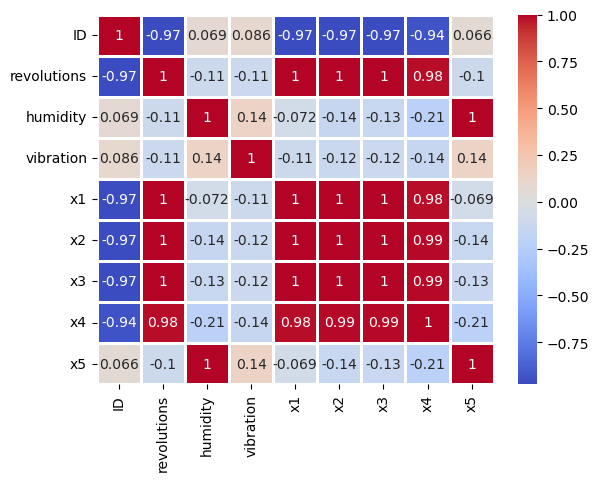

In [33]:
import seaborn as sns

sns.heatmap(data.corr(),annot=True,linewidths=1,cmap='coolwarm')

### Some observations:

Vibration has a moderate positive correlation with humidity (0.136) and weak negative correlations with other features.

All x data are highly correlated with each other, indicating potential redundancy

Revolutions, and x data (all but x5) are highly correlated

Humidity and x5 has a strong correlation

In [42]:
# lets remove ID (it is not neccessary to keep it)

data.duplicated().sum() # want to be shure we have no duplicates

data.drop('ID',axis=1,inplace=True)

### Scaling + PCA

Since we have highly correlated features such as x1, x2, x3, and x4, one common approach is to reduce multicollinearity by `Dimensionality Reduction techniques`: Using techniques like `Principal Component Analysis` (PCA)

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109563 entries, 0 to 112000
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   revolutions  109563 non-null  float64
 1   humidity     109563 non-null  float64
 2   vibration    109563 non-null  float64
 3   x1           109563 non-null  float64
 4   x2           109563 non-null  float64
 5   x3           109563 non-null  float64
 6   x4           109563 non-null  float64
 7   x5           109563 non-null  float64
dtypes: float64(8)
memory usage: 7.5 MB


In [62]:
# lets split target from the features

X = data.copy()
y = X.pop('vibration')

In [70]:
# it is recommended to scale the features before PCA
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['x1', 'x2', 'x3', 'x4']] = scaler.fit_transform(X[['x1', 'x2', 'x3', 'x4']])

pca = PCA(n_components=1)  # Reduce to 1 principal component
X_scaled['pca_x'] = pca.fit_transform(X_scaled[['x1', 'x2', 'x3', 'x4']])
X_scaled = X_scaled.drop(columns=['x1', 'x2', 'x3', 'x4'])

<Axes: >

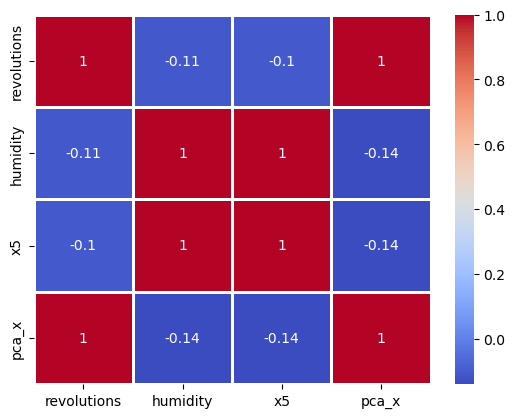

In [74]:
correlation_matrix = X_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=1,cmap='coolwarm')

In [92]:
# still, we have highly correlated features. Lets simply drop them
X_final = X_scaled.drop(columns=['pca_x', 'x5'])

In [94]:
X_final.head(3)

,revolutions,humidity
0,93.744,73.999
1,93.740,73.999
2,93.736,73.998


## 3. Model

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_final,y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('model', LinearRegression())  # Linear Regression model
])

In [153]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import numpy as np

# I want to make a cross-validation framework and a DataFrame to store performance metrics for different models.

metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE', 'RMSE', 'R2'])

def calculate_metrics(model, X, y):
    mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    rmse = np.sqrt(mse)
    r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()
    return mse, mae, rmse, r2

In [155]:
mse, mae, rmse, r2 = calculate_metrics(pipeline,X_train,y_train)
metrics_df = pd.concat([metrics_df, pd.DataFrame({'Model': ['Linear Regression'], 'MSE': [mse], 'MAE': [mae], 'RMSE': [rmse], 'R2': [r2]})], ignore_index=True)

In [157]:
metrics_df

,Model,MSE,MAE,RMSE,R2
0,Linear Regression,574.378411,19.407187,23.966193,0.028011


In [163]:
from sklearn.tree import DecisionTreeRegressor

dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=42))
])

mse_dt, mae_dt, rmse_dt, r2_dt = calculate_metrics(dt_pipeline, X_train, y_train)

new_metrics_dt = pd.DataFrame({
    'Model': ['Decision Tree'],
    'MSE': [mse_dt],
    'MAE': [mae_dt],
    'RMSE': [rmse_dt],
    'R2': [r2_dt]
})
metrics_df = pd.concat([metrics_df, new_metrics_dt], ignore_index=True)

In [170]:
from sklearn.ensemble import GradientBoostingRegressor

gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('model', GradientBoostingRegressor(random_state=42))
])


mse_gb, mae_gb, rmse_gb, r2_gb = calculate_metrics(gb_pipeline, X_train, y_train)

new_metrics_gb = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'MSE': [mse_gb],
    'MAE': [mae_gb],
    'RMSE': [rmse_gb],
    'R2': [r2_gb]
})
metrics_df = pd.concat([metrics_df, new_metrics_gb], ignore_index=True)

In [ ]:
from sklearn.svm import SVR

svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

mse_svr, mae_svr, rmse_svr, r2_svr = calculate_metrics(svr_pipeline, X_train, y_train)

new_metrics_svr = pd.DataFrame({
    'Model': ['Support Vector Regressor'],
    'MSE': [mse_svr],
    'MAE': [mae_svr],
    'RMSE': [rmse_svr],
    'R2': [r2_svr]
})
metrics_df = pd.concat([metrics_df, new_metrics_svr], ignore_index=True)

In [161]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('model', RandomForestRegressor(n_estimators=10,random_state=42))  # Random Forest model
])

mse_rf, mae_rf, rmse_rf, r2_rf = calculate_metrics(rf_pipeline, X_train, y_train)

new_metrics = pd.DataFrame({
    'Model': ['Random Forest'],
    'MSE': [mse_rf],
    'MAE': [mae_rf],
    'RMSE': [rmse_rf],
    'R2': [r2_rf]
})
metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)

KeyboardInterrupt: 